In [1]:
import argparse
import os
import requests
from datetime import datetime
import json

from lib.utils import *
from lib.models import CNN_0
from lib.datasets import EEGDataset
from torch.utils.data import DataLoader
from torch.nn.functional import softmax
from torch import nn

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = EEGDataset(dir='data/pt/test',labels='data/pt/y_test.pt')
train_dataloader = DataLoader(EEGDataset(dir='data/pt/train',labels='data/pt/y_train.pt'), batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=False)

In [3]:
model = CNN_0()

In [6]:
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
training_losses = []
testing_losses = []

pbar = tqdm(range(10))
for epoch in pbar:
    training_loss = 0
    for mbi,(X,y) in enumerate(train_dataloader):
        X,y = X.cuda(),y.cuda()
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    training_loss = training_loss/len(train_dataloader)
    training_losses.append(training_loss)
    model.eval()
    testing_loss = 0
    for (X,y) in test_dataloader:
        X,y = X.cuda(),y.cuda()
        logits = model(X)
        loss = criterion(logits,y)
        testing_loss += loss.item()
    testing_loss = testing_loss/len(test_dataloader)
    testing_losses.append(testing_loss)
plt.plot(training_losses)
plt.savefig('loss.jpg',dpi=50)
plt.close()

100%|██████████| 10/10 [06:07<00:00, 36.79s/it]


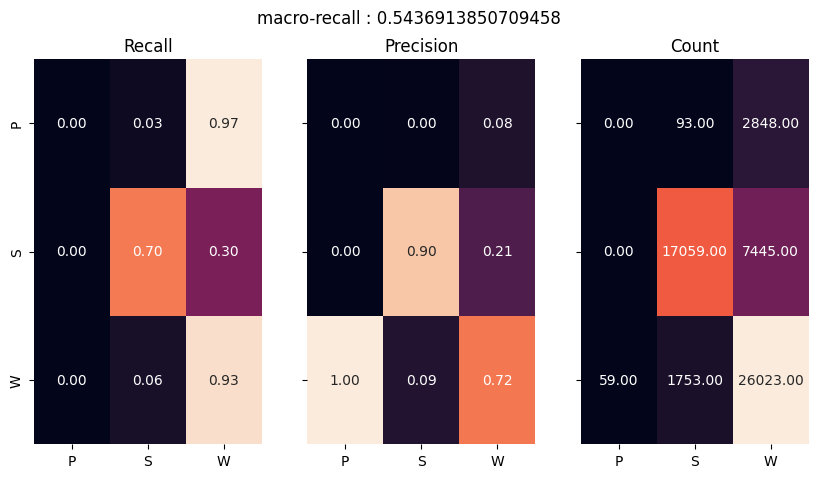

In [7]:
# test confusion matrices
y_true = [test[i][1].argmax(axis=0).item() for i in range(len(test))]
y_pred = torch.Tensor().cuda()
for (X,_) in test_dataloader:   
    y_pred = torch.cat([y_pred,softmax(model(X.cuda()),dim=1).argmax(axis=1)])
y_pred = y_pred.cpu()
cms(y_true=y_true,y_pred=y_pred)

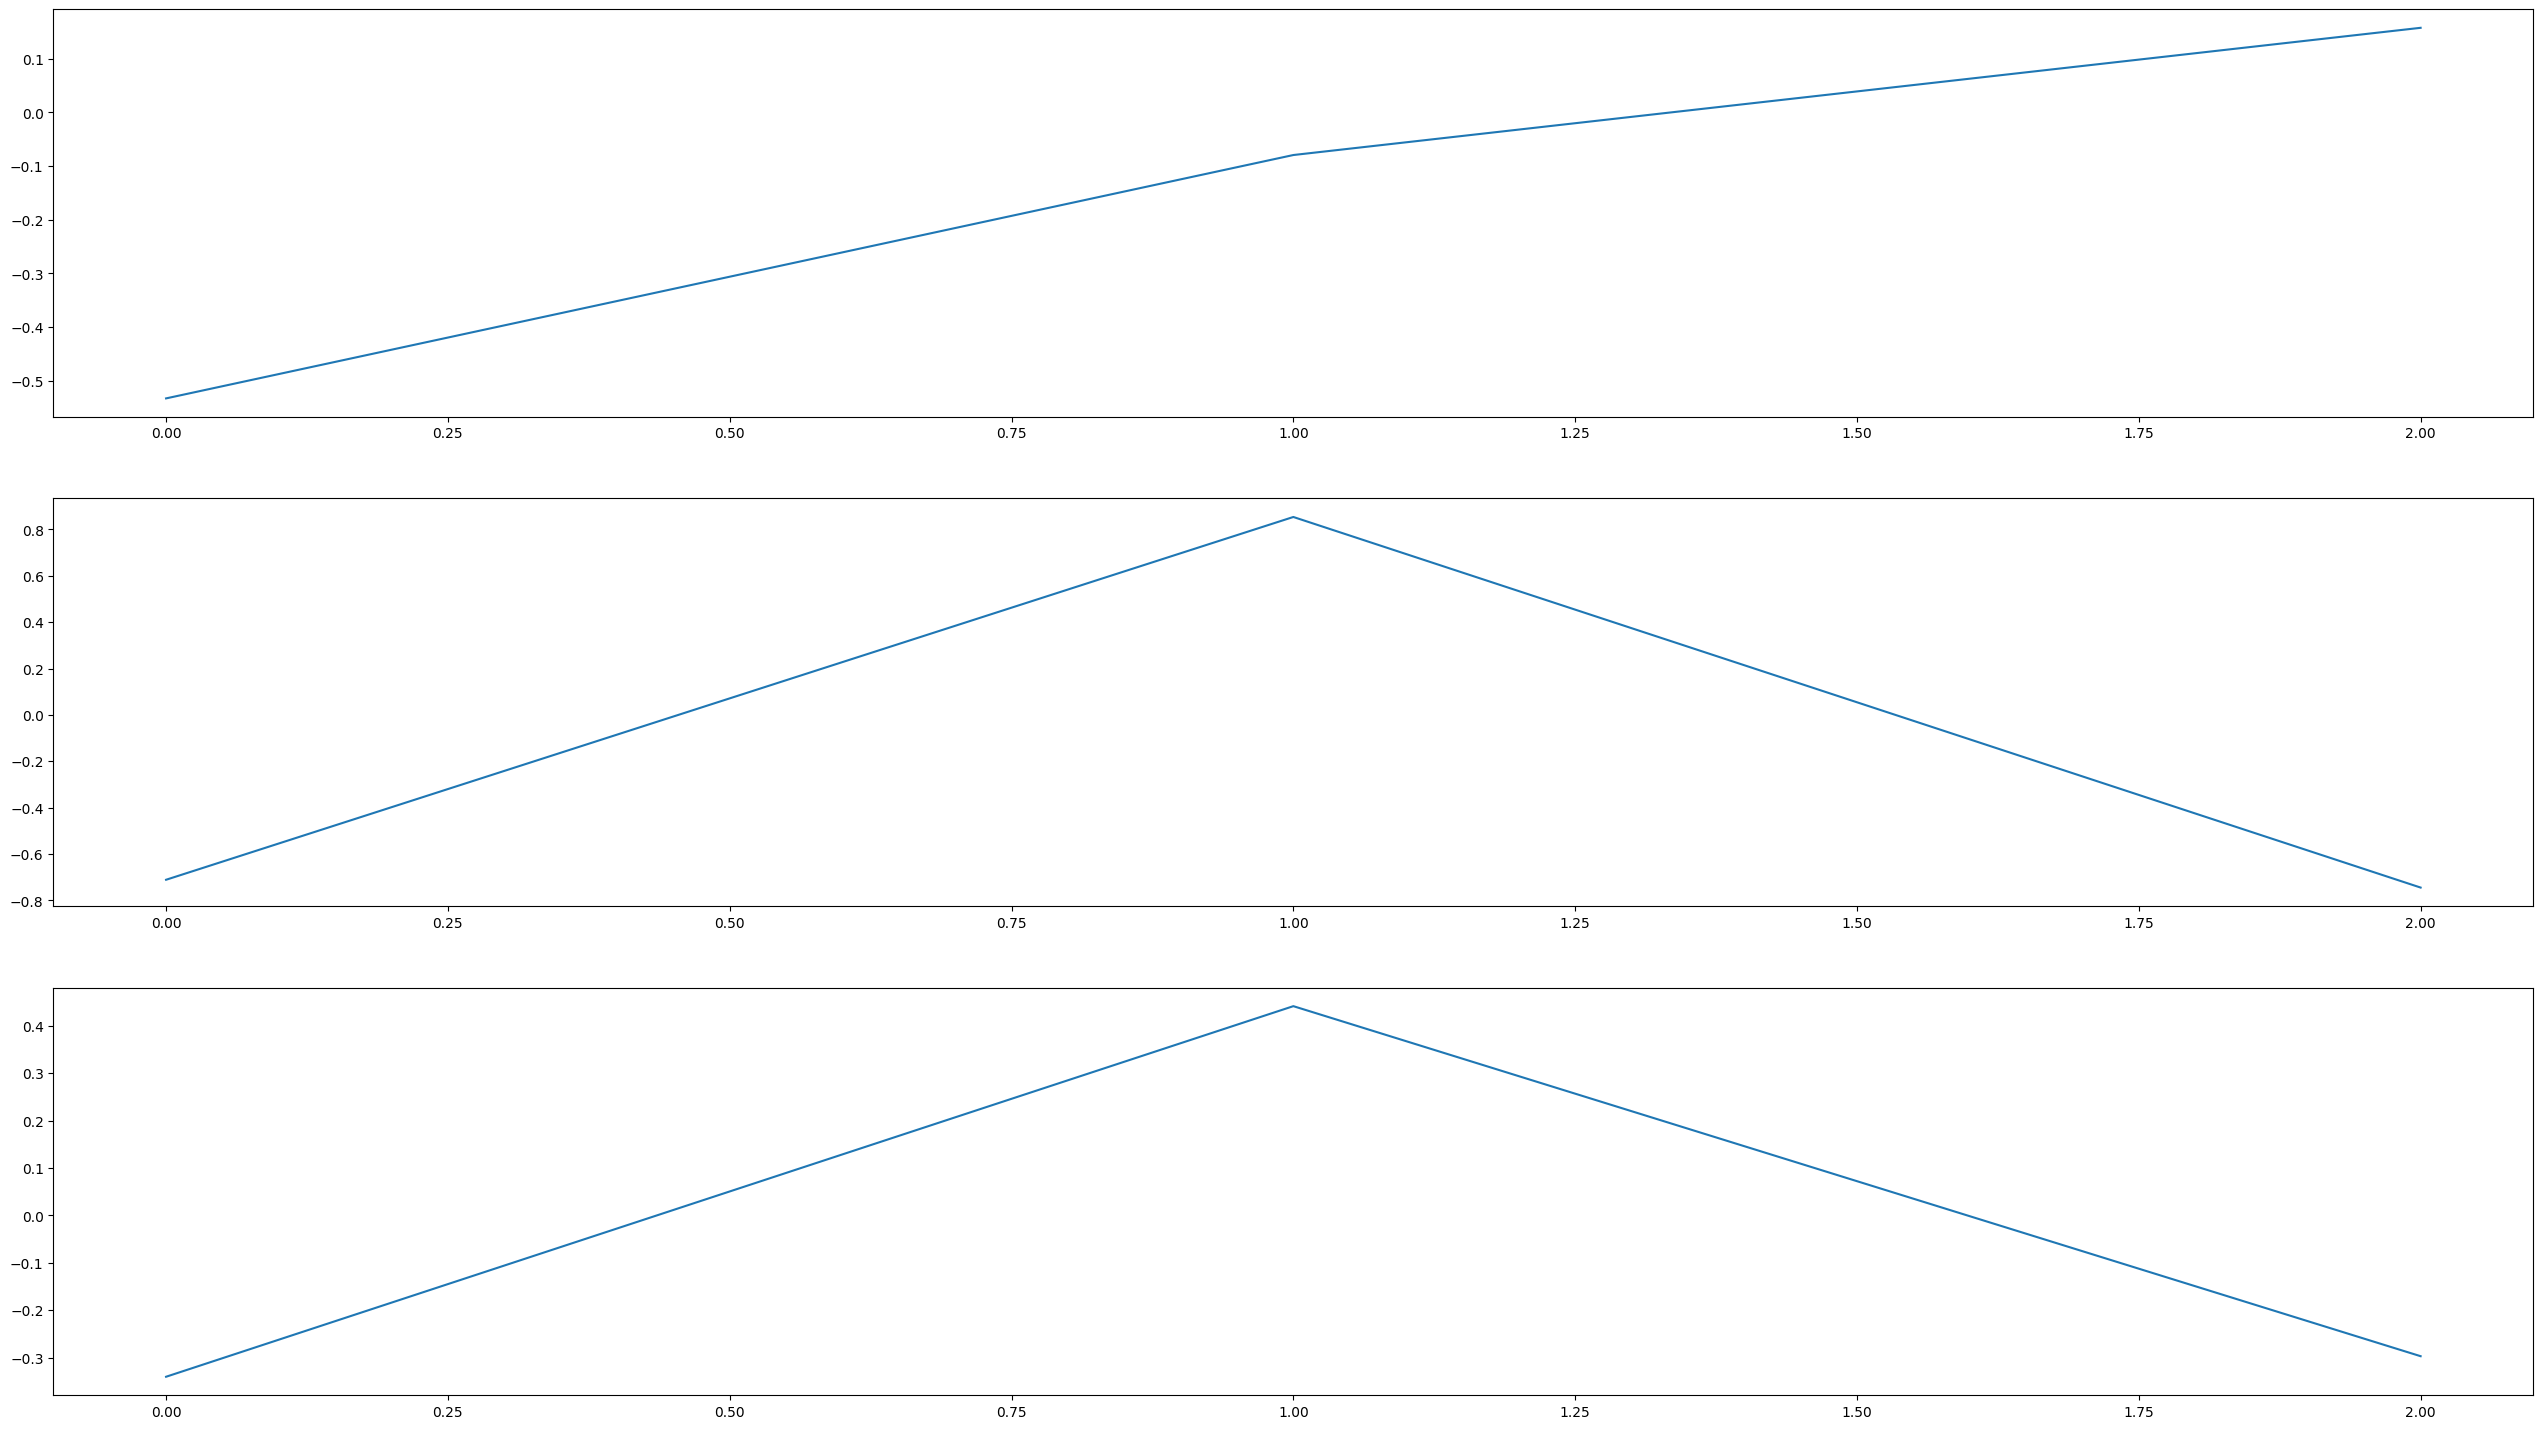

In [17]:
fig,axes = plt.subplots(nrows=len(model.c1.weight),ncols=1,figsize=(32,18))
for i in range(len(model.c1.weight)):
    axes[i].plot(model.c1.weight[i].squeeze().detach().cpu())
plt.savefig('figures/kernels.jpg',dpi=500)